# Analisi dei contagi da COVID-19 nella regione Friuli Venezia Giulia
Esame di Tecniche di Rappresentazione e Modellizzazione Dati - Stefano Rascazzo.

Questo esercizio ha come scopo l'analisi dell'andamento dei contagi COVID-19 in Friuli Venezia Giulia, utilizzando i dati forniti dalla Protezione Civile Italiana.

## Parte 1
* Scaricare il dataset dei contagi COVID dal repository della Protezione Civile.
* Graficare l'andamento dei nuovi contagi giornalieri (flag 'nuovi_positivi') per la regione prestabilita.

Innanzitutto, iniziamo importando le librerie necessarie.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import emcee
from scipy.optimize import minimize
from scipy.stats import poisson

Procediamo con l'estrarre i dati dal file 'covid.csv' utilizzando la libreria `pandas`, eliminando le colonne che di sicuro non serviranno.

In [5]:
data = pd.read_csv('covid.csv',index_col='data',parse_dates=True)
data.drop(['stato','codice_regione','lat','long','note'],axis=1,inplace=True)
gruppi=data[data['denominazione_regione']=='Friuli Venezia Giulia']

Può risultare utile rappresentare in un grafico l'andamento dei contagi per tutto il periodo di tempo preso in esame. 

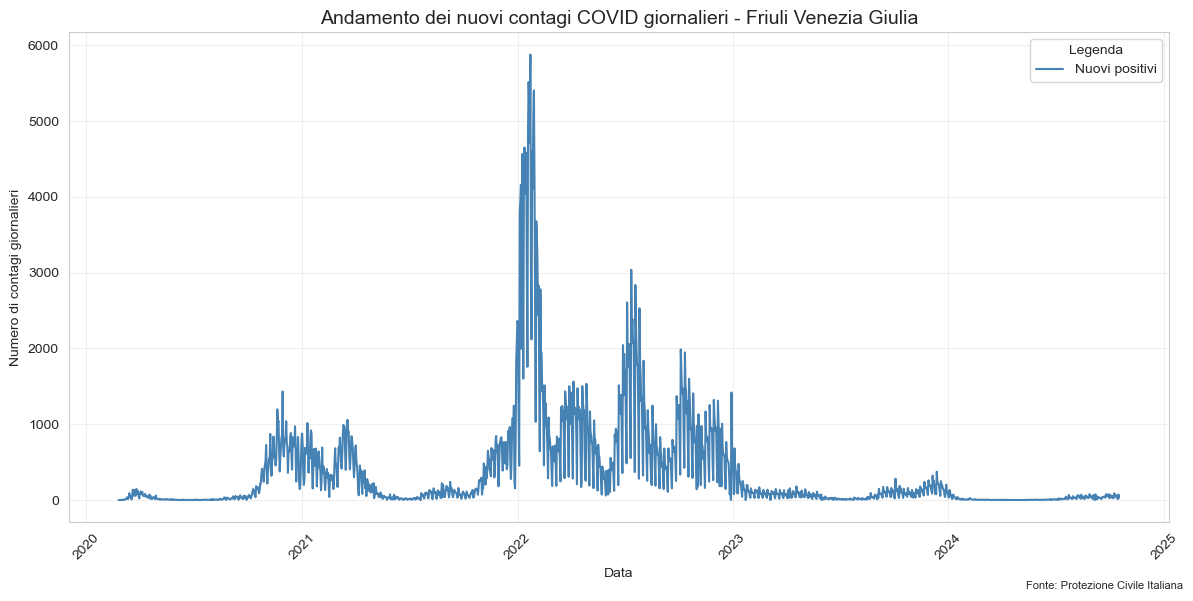

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))
sns.lineplot(x=gruppi.index,y=gruppi['nuovi_positivi'], color='steelblue', label='Nuovi positivi')

plt.title('Andamento dei nuovi contagi COVID giornalieri - Friuli Venezia Giulia', fontsize=14)
plt.xlabel('Data')
plt.ylabel('Numero di contagi giornalieri')
plt.xticks(rotation=45)
plt.legend(title='Legenda', loc='upper right')
plt.grid(True, alpha=0.3)
plt.figtext(0.99, 0.01, 'Fonte: Protezione Civile Italiana', ha='right', fontsize=8)
plt.tight_layout()

Nel grafico vediamo appunto dei picchi (le ondate) che si verificano in maniera più intensa nel corso dell'anno 2022. Tuttavia, ai fini dell'esame, l'intervallo di tempo preso in considerazione non va oltre giugno del 2021. Per vedere un andamento generale, senza le fluttuazioni caratteristiche di un sampling giornaliero, ho deciso anche di fare un resample mensile dei nuovi contagi:

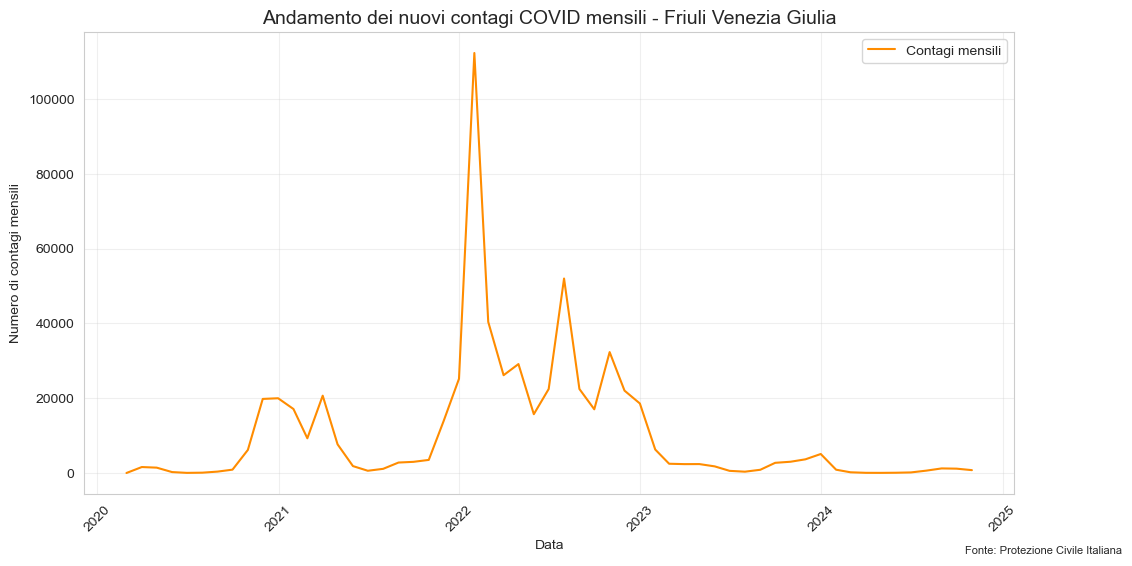

In [23]:
monthly=gruppi['nuovi_positivi'].resample('ME').sum()

plt.figure(figsize=(12, 6))

sns.lineplot(x=monthly.index, y=monthly.values, color='darkorange', label='Contagi mensili')
plt.title('Andamento dei nuovi contagi COVID mensili - Friuli Venezia Giulia', fontsize=14)
plt.xlabel('Data')
plt.figtext(0.99, 0.01, 'Fonte: Protezione Civile Italiana', ha='right', fontsize=8)
plt.ylabel('Numero di contagi mensili')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

## Parte 2
Scrivere delle funzioni in Python per implementare:
* la funzione Logistica;
* la funzione di Gompertz;
* I nuovi contagi giornalieri predetti dalle due funzioni (la differenza dei contagi predetti
tra il giorno $i+1$ ed il giorno $i$);

Utilizzare queste funzioni per modellare l'andamento dei nuovi contagi, analizzando
come i contagi cambiano al variare dei parametri di queste funzioni.

La funzione *logistica* è definita come segue:
$$N(<t)=\dfrac{N_{tot}}{1+e^{-k(t-t_0)}} \ .$$
Allo stesso modo, la funzione di Gompertz è:
$$N(<t)=N_{tot}\ e^{-\ln(N_{tot})e^{-k(t-t_0)}} \ .$$

Dunque inizio definendo delle funzioni in modo da poter calcolare i nuovi casi giornalieri a partire da uno qualunque dei modelli scritti sopra.

In [9]:
def logistic(t, N_tot, k, t0):
    """Modello con la funzione logistica"""
    return N_tot / (1 + np.exp(-k * (t - t0)))

def gompertz(t, N_tot, k, t0):
    """Modello con la funzione di Gompertz"""
    return N_tot * np.exp(-np.log(N_tot)*np.exp(-k * (t - t0)))

def casi_giornalieri(modello, i, N_tot, k, t0):
    """Nuovi contagi giornalieri previsti"""
    return modello(i+1, N_tot, k, t0) - modello(i, N_tot, k, t0)

N_tot = 1000.  
k = 0.07        
t0 = 0.       

giorni = np.arange(len(gruppi))
log_pred = [casi_giornalieri(logistic, i, N_tot, k, t0) for i in giorni]
gomp_pred = [casi_giornalieri(gompertz, i, N_tot, k, t0) for i in giorni]

In questo caso, i parametri iniziali sono stati scelti "ad occhio", puramente per vedere come sono fatte queste funzioni.

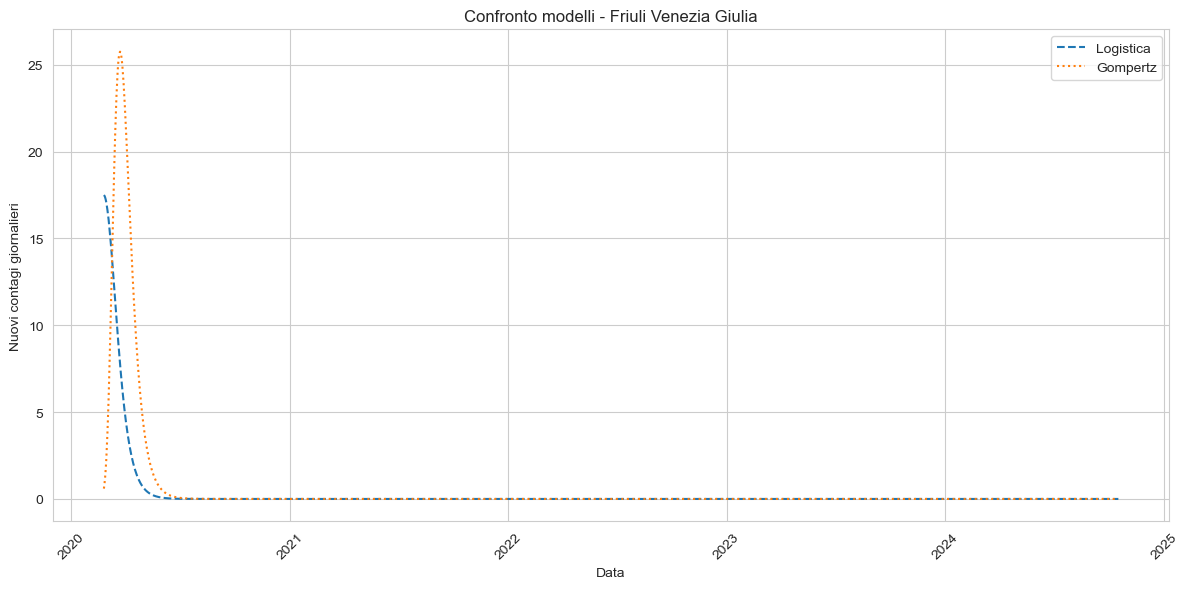

In [11]:
plt.figure(figsize=(12,6))
plt.plot(gruppi.index, log_pred, label='Logistica', linestyle='--')
plt.plot(gruppi.index, gomp_pred, label='Gompertz', linestyle=':')
plt.xlabel('Data')
plt.ylabel('Nuovi contagi giornalieri')
plt.title('Confronto modelli - Friuli Venezia Giulia')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

Di seguito, ho fatto variare i parametri $k$ e $t_0$ a partire da una lista di valori in modo da vedere l'effetto di questi parametri sulle funzioni.

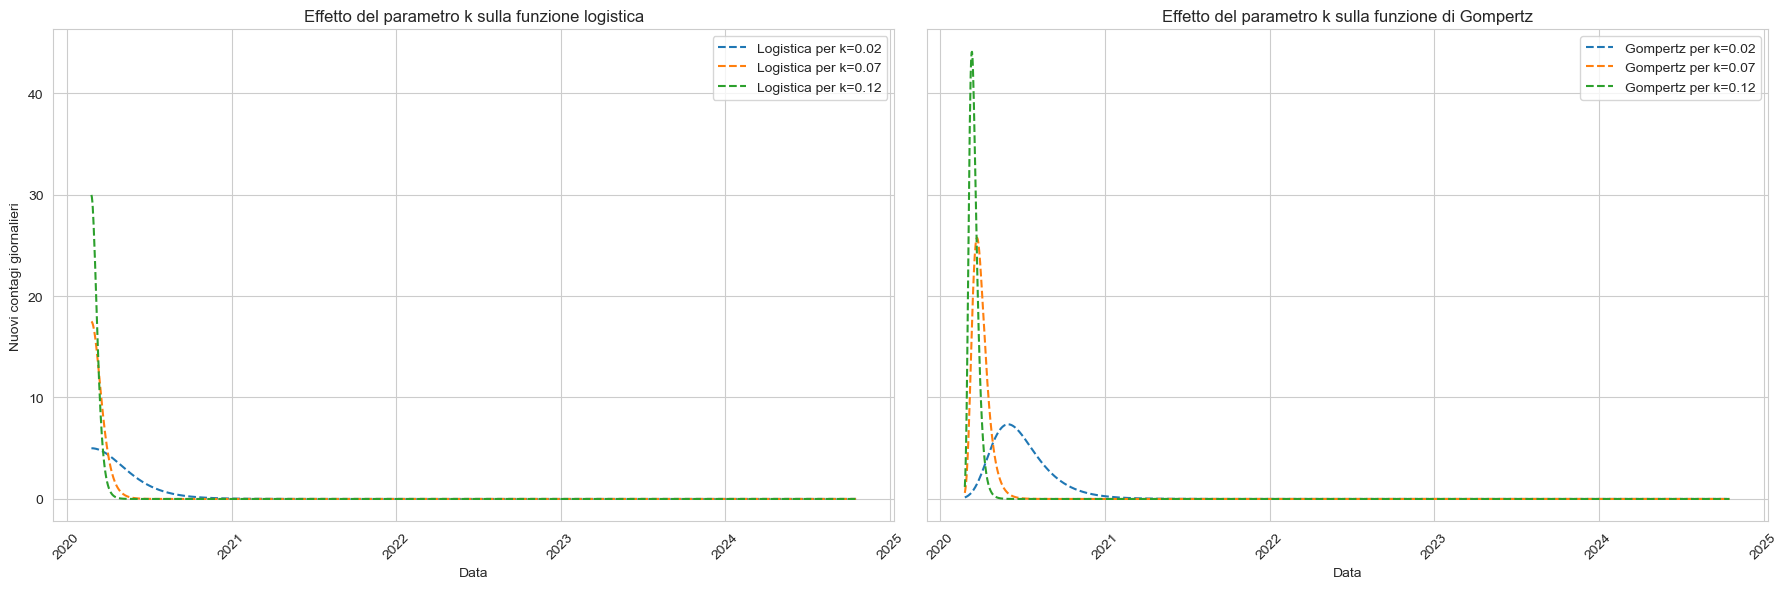

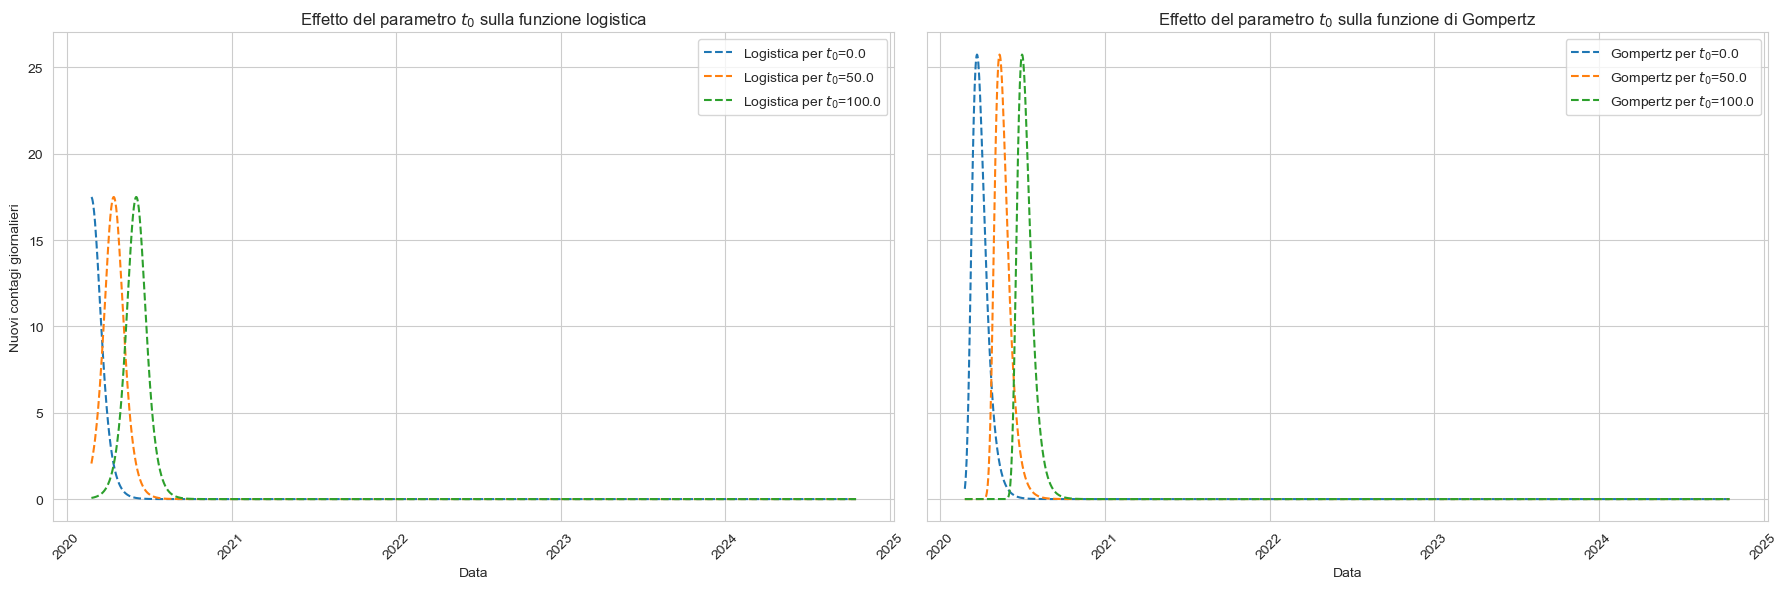

In [35]:
#Effetto della variazione di k

k_v = [0.02,0.07,0.12]        

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

for k in k_v:
    log_pred = [casi_giornalieri(logistic, i, N_tot, k, t0) for i in giorni]
    ax1.plot(gruppi.index, log_pred, label=f'Logistica per k={k}', linestyle='--')
ax1.set_xlabel('Data')
ax1.set_ylabel('Nuovi contagi giornalieri')
ax1.set_title('Effetto del parametro k sulla funzione logistica')
ax1.legend()
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

for k in k_v:
    gomp_pred = [casi_giornalieri(gompertz, i, N_tot, k, t0) for i in giorni]
    ax2.plot(gruppi.index, gomp_pred, linestyle='--',label=f'Gompertz per k={k}')
ax2.set_xlabel('Data')
ax2.set_title('Effetto del parametro k sulla funzione di Gompertz')

ax2.legend()
ax2.grid(True)
ax2.tick_params(axis='x', rotation=45)
plt.tight_layout()


#Effetto della variazione di t0

k=0.07
t0_v = [0.,50.,100.]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

for t0 in t0_v:
    log_pred = [casi_giornalieri(logistic, i, N_tot, k, t0) for i in giorni]
    ax1.plot(gruppi.index, log_pred, label=f'Logistica per $t_0$={t0}', linestyle='--')
ax1.set_xlabel('Data')
ax1.set_ylabel('Nuovi contagi giornalieri')
ax1.set_title('Effetto del parametro $t_0$ sulla funzione logistica')
ax1.legend()
ax1.grid(True)
ax1.tick_params(axis='x',rotation=45)

for t0 in t0_v:
    gomp_pred = [casi_giornalieri(gompertz, i, N_tot, k, t0) for i in giorni]
    ax2.plot(gruppi.index, gomp_pred, linestyle='--',label=f'Gompertz per $t_0$={t0}')
ax2.set_xlabel('Data')
ax2.set_title('Effetto del parametro $t_0$ sulla funzione di Gompertz')
ax2.legend()
ax2.grid(True)
ax2.tick_params(axis='x',rotation=45)
plt.tight_layout()

Dunque, come già anticipato nella traccia, si vede che $t_0$ corrisponde puramente a una **traslazione** sull'asse dei tempi, mentre il parametro $k$ governa la **velocità di propagazione del contagio**. Da questi grafici e da quello precedente, notiamo inoltre che $t_0$ nella funzione logistica corrisponde al valore massimo di contagi, mentre nella funzione di Gompertz corrisponde al momento in cui i contagi iniziano a verificarsi.

## Parte 3: Analisi della Prima Ondata

1. Concentrarsi sull'andamento dei contagi nella regione prestabilita durante i primi 35 giorni dalla comparsa dei primi casi (30 marzo 2020).
2. Supporre che i nuovi contagi giornalieri siano una realizzazione poissoniana con un valore di aspettazione dato dalla funzione logistica (e di Gompertz).
3. Scrivere una funzione per la likelihood poissoniana e utilizzarla per vincolare i valori dei parametri del modello.
4. Confrontare le previsioni del modello con i dati effettivi, propagando l'incertezza teorica associata al modello. Analizzare come la predizione fatta dopo i primi 35 giorni possa corrispondere all'andamento osservato nei primi 100 giorni (sia giornaliero sia cumulativo).
5. Commentare i risultati e i limiti dell’analisi

Iniziamo innanzitutto isolando l'intervallo di tempo desiderato.

In [13]:
start=pd.to_datetime('2020-02-24')
end=pd.to_datetime('2020-03-30')
gruppi35=gruppi.loc[start:end].copy() #.copy() è una misura di sicurezza
gruppi35['Giorno'] = (gruppi35.index - start).days

Per stimare i parametri delle due funzioni, ho utilizzato l'algoritmo **MCMC** tramite la libreria `emcee`, adottando come funzione di verosimiglianza (likelihood) la distribuzione di **Poisson**, come indicato nella traccia. Ovviamente stiamo usando le basi dell'*inferenza bayesiana*:
$$P(p \mid d, M) = \frac{P(d \mid p, M) \cdot P(p \mid M)}{P(d \mid M)}\ ,$$

dove $P(p \mid d, M)$ è il *posterior*, $P(d \mid p, M)$ è la *verosimiglianza*, $P(p \mid M)$ è il *prior* e $P(d \mid M)$ è l'*evidenza* (normalizzatore).

La distribuzione di Posson è descritta dalla seguente espressione:
$$\mathcal{L}(\theta) = \prod_{i=1}^{n} \frac{\lambda_i^{y_i} e^{-\lambda_i}}{y_i!}\ .$$
Dove $y_i$ è il valore osservato, mentre $\lambda_i$ è il valore predetto dal modello (logistico o Gompertz) per il giorno $i$-esimo.
Quando prendiamo il logaritmo di tale espressione, la produttoria si trasforma in una sommatoria per la proprietà dei logaritmi e il termine del fattoriale, che è costante, non influisce nella ricerca del minimo e dunque nella trattazione sarà ignorato.

Inizio definendo le funzioni prior, likelihood e posterior.

In [15]:
def log_prior(theta):
    Ntot, k, t0= theta
    if 0<Ntot<1e6 and k>=0 and -50<t0<100:
        return 0.0
    return -np.inf

def log_likelihood(theta, modello,t_v,y_v):
    Ntot, k, t0 = theta
    ni = [casi_giornalieri(modello,t,Ntot,k,t0) for t in t_v]
    ni = np.maximum(ni, 1e-3)
    return np.sum(y_v*np.log(ni)-ni)

def log_posterior(theta, modello,t_v,y_v):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, modello,t_v,y_v)

nll= lambda *args: -log_posterior(*args)
t_v = gruppi35['Giorno'].values
y_v = gruppi35['nuovi_positivi'].values

Procedo dunque con i preparativi per l'algoritmo MCMC.

In [17]:
initial = np.array([1000,0.1,5])
soln_l = minimize(nll, initial, args=(logistic, t_v ,y_v ))
soln_g = minimize(nll, initial, args=(gompertz, t_v ,y_v ))
Ntot_bf, k_bf, t0_bf = soln_l.x
Ntot_bf, k_bf, t0_bf = soln_g.x
print(soln_l.x)
print(soln_g.x)
np.random.seed(42)
pos_log = soln_l.x * (1 + 1e-6 * np.random.randn(32, 3))
nwalkers,ndim=pos_log.shape
pos_gom = soln_g.x * (1 + 1e-6 * np.random.randn(32, 3))

/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1.90529908e+03 2.08757575e-01 2.89602370e+01]
[3.16509046e+03 7.81968322e-02 4.80102162e+00]


In [19]:
sampler_log = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(logistic,t_v,y_v))
sampler_gom = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(gompertz,t_v,y_v))

sampler_log.run_mcmc(pos_log,2000,progress=True)
sampler_gom.run_mcmc(pos_gom,2000,progress=True)


samples_log = sampler_log.get_chain(discard=100)
samples_gom = sampler_gom.get_chain(discard=100)

100%|███████████████████████████████████████| 2000/2000 [00:22<00:00, 88.76it/s]


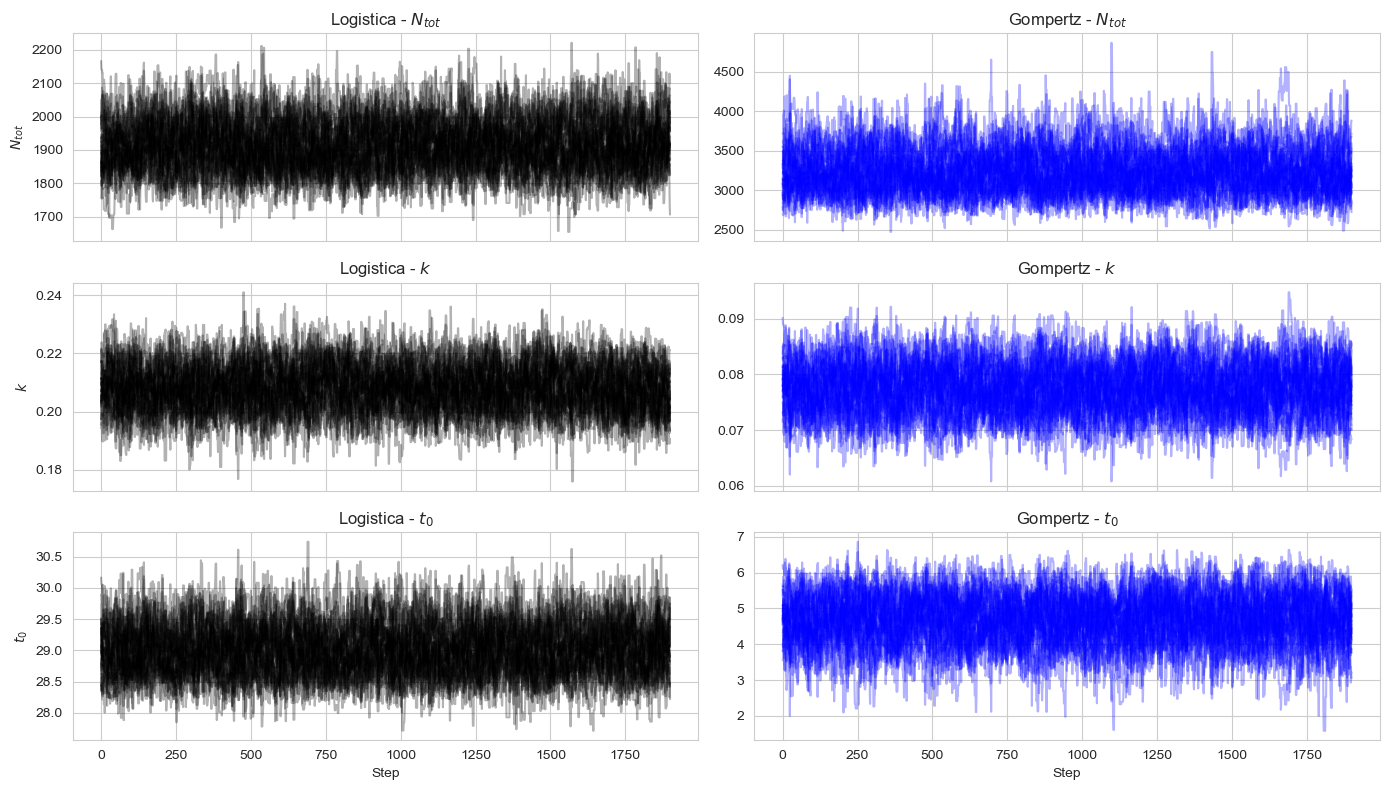

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(14, 8), sharex=True)
labels = ['$N_{tot}$', '$k$', '$t_0$']

for i in range(ndim):
    axes[i,0].plot(samples_log[:, :, i], 'k', alpha=0.3)
    axes[i,0].set_ylabel(labels[i])
    axes[i,0].set_title(f'Logistica - {labels[i]}')
    axes[i,1].plot(samples_gom[:, :, i], 'b', alpha=0.3)
    axes[i,1].set_title(f'Gompertz - {labels[i]}')

axes[-1,0].set_xlabel('Step')
axes[-1,1].set_xlabel('Step')
plt.tight_layout()


Dalla convergenza del parametro $t_0$ notiamo che effettivamente per la funzione logistica esso è l'istante in cui la funzione logistica predice i contagi massimi, mentre per la funzione di Gompertz corrisponde all'inizio dei contagi (circa 4 giorni dopo l'inizio del dataset).
Ora tengo in considerazione i primi **100 giorni** e vedo come le previsioni dei modelli con i parametri appena calcolati sono vicine ai dati reali, graficando i risultati. Questa operazione la faccio sia per i primi 35 giorni che per i primi 100.

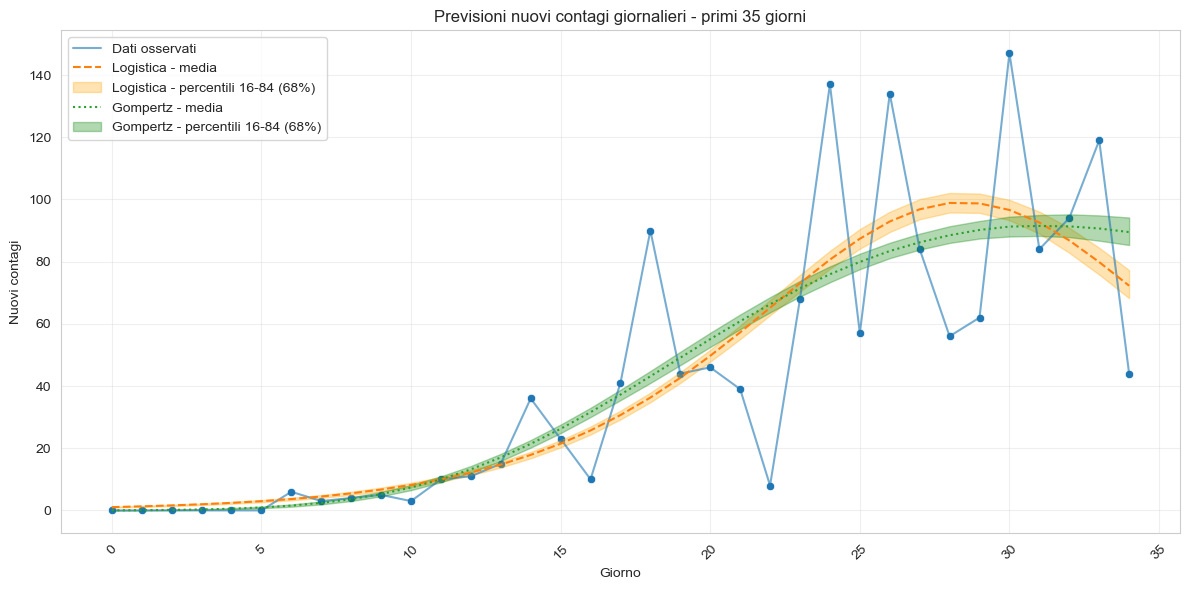

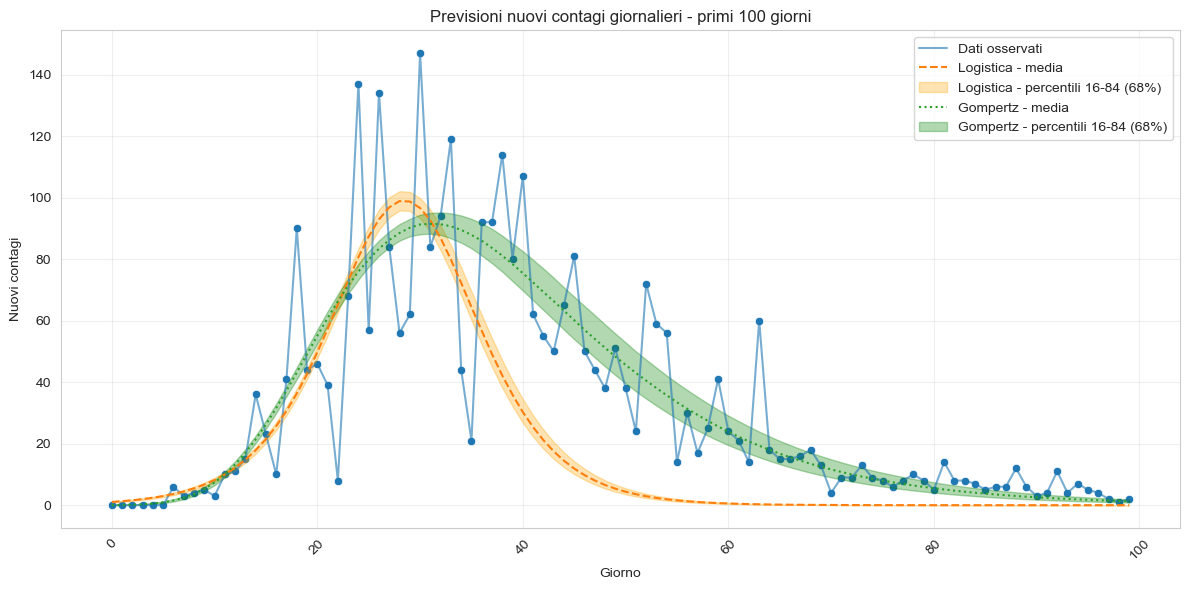

In [23]:
start = pd.to_datetime('2020-02-24')
end=start + pd.Timedelta(days=100)
gruppi100=gruppi.loc[start:end].copy()
gruppi100['Giorno'] = (gruppi100.index - start).days
t_v100 = gruppi100['Giorno'].values
y_v100 = gruppi100['nuovi_positivi'].values

flat_log = sampler_log.get_chain(discard=100, flat=True)
flat_gom = sampler_gom.get_chain(discard=100, flat=True)

def sample_prediction(samples, modello, giorni):
    prediction=[]
    for theta in samples[::100]:
        N_tot, k, t0 = theta
        pred = [casi_giornalieri(modello, t, N_tot, k, t0) for t in giorni]
        prediction.append(pred)
    return np.array(prediction)

prediction_log=sample_prediction(flat_log,logistic,range(35))
prediction_gom=sample_prediction(flat_gom,gompertz,range(35))

low_log, med_log, up_log = np.percentile(prediction_log, [16, 50, 84], axis=0)
low_gom, med_gom, up_gom = np.percentile(prediction_gom, [16, 50, 84], axis=0)

plt.figure(figsize=(12,6))
sns.scatterplot(x=gruppi35['Giorno'], y=y_v)
sns.lineplot(x=gruppi35['Giorno'], y=y_v, label='Dati osservati', alpha=0.6)
sns.lineplot(x=gruppi35['Giorno'], y=med_log,linestyle= '--', label='Logistica - media')
plt.fill_between(gruppi35['Giorno'], low_log, up_log, color='orange',alpha=0.3, label=r'Logistica - percentili 16-84 (68%)')
sns.lineplot(x=gruppi35['Giorno'], y=med_gom, linestyle=':', label='Gompertz - media')
plt.fill_between(gruppi35['Giorno'], low_gom, up_gom, color='green',alpha=0.3, label=r'Gompertz - percentili 16-84 (68%)')
plt.title('Previsioni nuovi contagi giornalieri - primi 35 giorni')
plt.xlabel('Giorno')
plt.ylabel('Nuovi contagi')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()


prediction_log=sample_prediction(flat_log,logistic,range(100))
prediction_gom=sample_prediction(flat_gom,gompertz,range(100))

low_log, med_log, up_log = np.percentile(prediction_log, [16, 50, 84], axis=0)
low_gom, med_gom, up_gom = np.percentile(prediction_gom, [16, 50, 84], axis=0)

plt.figure(figsize=(12,6))
sns.scatterplot(x=gruppi100['Giorno'], y=y_v100)
sns.lineplot(x=gruppi100['Giorno'], y=y_v100, label='Dati osservati', alpha=0.6)
sns.lineplot(x=gruppi100['Giorno'], y=med_log,linestyle= '--', label='Logistica - media')
plt.fill_between(gruppi100['Giorno'], low_log, up_log, color='orange',alpha=0.3, label=r'Logistica - percentili 16-84 (68%)')
sns.lineplot(x=gruppi100['Giorno'], y=med_gom, linestyle=':', label='Gompertz - media')
plt.fill_between(gruppi100['Giorno'], low_gom, up_gom, color='green',alpha=0.3, label=r'Gompertz - percentili 16-84 (68%)')
plt.title('Previsioni nuovi contagi giornalieri - primi 100 giorni')
plt.xlabel('Giorno')
plt.ylabel('Nuovi contagi')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

Da questi grafici si vede che nei primi 35 giorni, quanto il contagio sta aumentando, la funzione logistica è, ad occhio, più adatta a descrivere questa prima fase di crescita. Al contrario, con l'avanzare dell'ondata, la decrescita dei contagi viene descritta visivamente molto meglio dalla **funzione di Gompertz**, mentre quella logistica, essendo **simmetrica**, sembra sottostimare i nuovi contagi. Ciò è coerente con quanto introdotto nella traccia.
Allo stesso modo, possiamo giungere alle stesse conclusioni osservando l'andamento **cumulativo** dei primi 100 giorni:

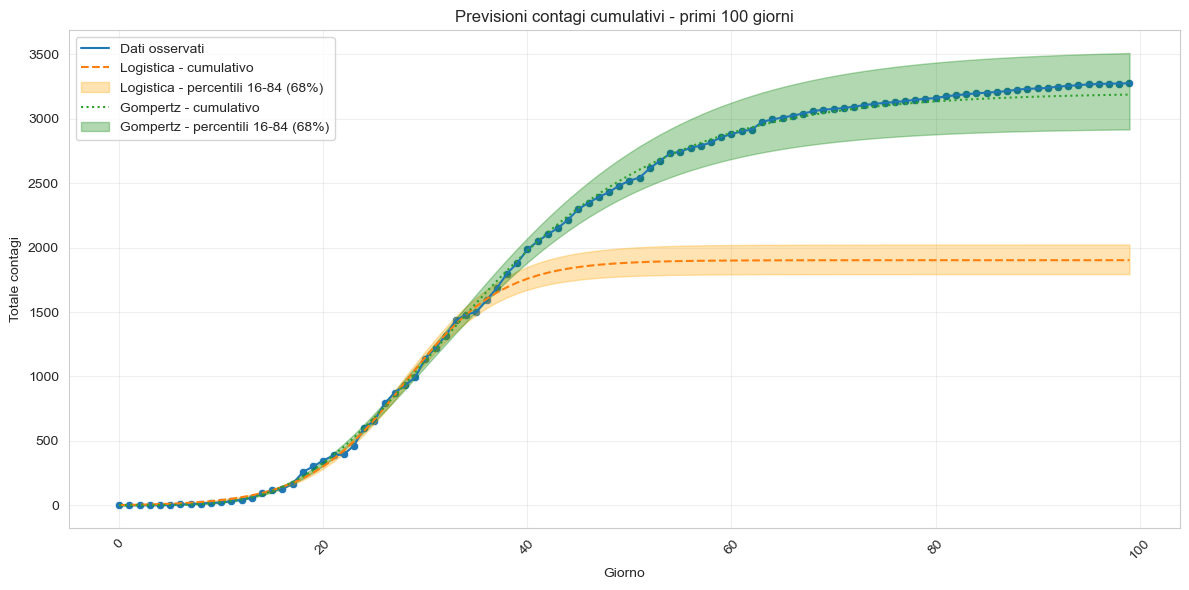

In [25]:
cumul_obs = np.cumsum(y_v100)
cumul_log = np.cumsum(med_log)
cumul_gom = np.cumsum(med_gom)
cumul_log_low = np.cumsum(low_log)
cumul_log_up = np.cumsum(up_log)
cumul_gom_low = np.cumsum(low_gom)
cumul_gom_up = np.cumsum(up_gom)

plt.figure(figsize=(12,6))
sns.scatterplot(x=gruppi100['Giorno'], y=cumul_obs)
sns.lineplot(x=gruppi100['Giorno'], y=cumul_obs, label='Dati osservati')
sns.lineplot(x=gruppi100['Giorno'], y=cumul_log,linestyle= '--', label='Logistica - cumulativo')
plt.fill_between(gruppi100['Giorno'], cumul_log_low, cumul_log_up,color='orange', alpha=0.3,label=r'Logistica - percentili 16-84 (68%)')
sns.lineplot(x=gruppi100['Giorno'], y=cumul_gom,linestyle= ':', label='Gompertz - cumulativo')
plt.fill_between(gruppi100['Giorno'], cumul_gom_low, cumul_gom_up,color='green', alpha=0.3,label=r'Gompertz - percentili 16-84 (68%)')
plt.title('Previsioni contagi cumulativi - primi 100 giorni')
plt.xlabel('Giorno')
plt.ylabel('Totale contagi')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

## Parte 4: Modellizzazione dell'intervallo 3 giugno 2020 - 3 giugno 2021
1. Considerare l'intervallo temporale tra il 3 giugno 2020 e il 3 giugno 2021.
2. Alla luce di quanto verificato precedentemente, come modellereste l’andamento epidemiologico in questo periodo?

Prendiamo in considerazione il periodo che va dal 3 giugno 2020 al 3 giugno 2021 e grafichiamo l'andamento dei contagi in questo lasso di tempo.

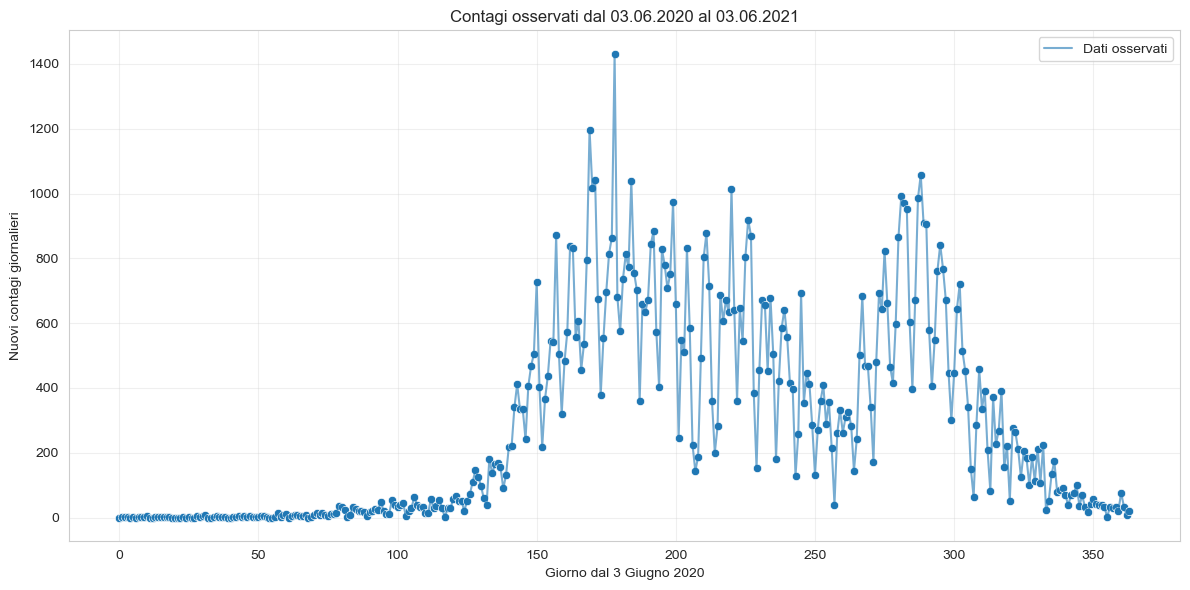

In [27]:
start = pd.to_datetime('2020-06-03')
end = start + pd.Timedelta(days=364)
gruppiy = gruppi.loc[start:end].copy()
gruppiy["Giorno"] = (gruppiy.index - start).days
giorni = gruppiy["Giorno"].values
y_v_annuale = gruppiy["nuovi_positivi"].values

plt.figure(figsize=(12, 6))
sns.scatterplot(x=gruppiy["Giorno"], y=y_v_annuale)
sns.lineplot(x=gruppiy["Giorno"], y=y_v_annuale, label="Dati osservati", alpha=0.6)
plt.xlabel("Giorno dal 3 Giugno 2020")
plt.ylabel("Nuovi contagi giornalieri")
plt.title("Contagi osservati dal 03.06.2020 al 03.06.2021")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Qui si vede una cruciale differenza dal caso precedente: ci sono due picchi consecutivi. Applicare uno qualsiasi dei due modelli quindi non avrebbe successo dato che sono pensati per avere un solo picco.
Una soluzione che può funzionare è di considerare la **somma** di più funzioni logistiche/di Gompertz, tenendo a mente però che al posto di 3 parametri, in questo se ne avranno **6**. 

In [29]:
start = pd.to_datetime('2020-06-03')
end = start + pd.Timedelta(days=364)
gruppiy = gruppi.loc[start:end].copy()
gruppiy["Giorno"] = (gruppiy.index - start).days
giorni = gruppiy["Giorno"].values
y_v_annuale = gruppiy["nuovi_positivi"].values

Per fittare le due funzioni, ho deciso di minimizzare lo scarto quadratico della predizione dai dati reali:
$$\sigma=\sum_{i}^{N}(y_i-\lambda_i)^2 \ .$$
I parametri iniziali li ho scelti "ad occhio" sfruttando le conoscenze acquisite nelle parti precedenti.

In [31]:
def errore_log(params, t, y):
    N1, k1, t01, N2, k2, t02 = params
    pred = np.array([casi_giornalieri(logistic, i, N1, k1, t01) + casi_giornalieri(logistic, i, N2, k2, t02) for i in t])
    return np.sum((y - pred) ** 2)

def errore_gom(params, t, y):
    N1, k1, t01, N2, k2, t02 = params
    pred = np.array([casi_giornalieri(gompertz, i, N1, k1, t01) + casi_giornalieri(gompertz, i, N2, k2, t02) for i in t])
    return np.sum((y - pred) ** 2)


inizio_log = [10000, 0.15, 100, 12000, 0.1, 250]
inizio_gom = [20000, 0.1, 50, 15000, 0.08, 200]

fit_log = minimize(errore_log, inizio_log, args=(giorni, y_v_annuale))
fit_gom = minimize(errore_gom, inizio_gom, args=(giorni, y_v_annuale))

/var/folders/31/16z86r0x4bl1h44dztf738340000gp/T/ipykernel_24631/705459378.py:7: RuntimeWarning: overflow encountered in exp
  return N_tot * np.exp(-np.log(N_tot)*np.exp(-k * (t - t0)))


In [32]:
params_log_fit = fit_log.x
params_gom_fit = fit_gom.x

pred_log_fit = np.array([casi_giornalieri(logistic, i, *params_log_fit[:3]) + casi_giornalieri(logistic, i, *params_log_fit[3:])for i in giorni])

pred_gom_fit = np.array([casi_giornalieri(gompertz, i, *params_gom_fit[:3]) + casi_giornalieri(gompertz, i, *params_gom_fit[3:]) for i in giorni])

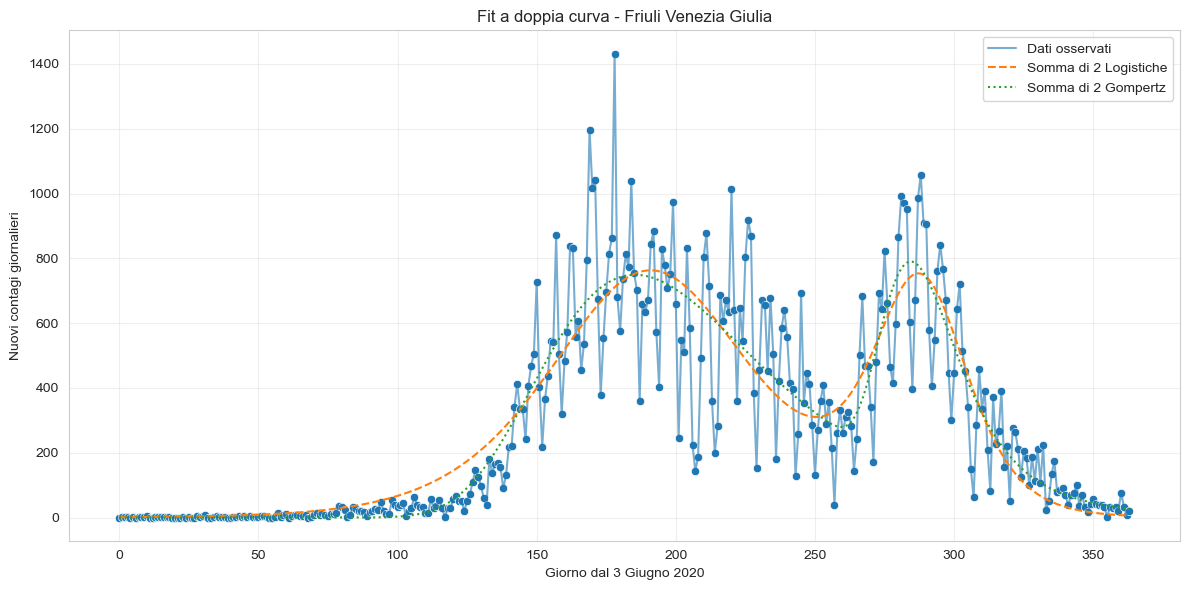

In [35]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=gruppiy["Giorno"], y=y_v_annuale)
sns.lineplot(x=gruppiy["Giorno"], y=y_v_annuale, label="Dati osservati", alpha=0.6)
sns.lineplot(x=gruppiy["Giorno"], y=pred_log_fit,linestyle= '--', label="Somma di 2 Logistiche")
sns.lineplot(x=gruppiy["Giorno"], y=pred_gom_fit, linestyle=':', label="Somma di 2 Gompertz")
plt.xlabel("Giorno dal 3 Giugno 2020")
plt.ylabel("Nuovi contagi giornalieri")
plt.title("Fit a doppia curva - Friuli Venezia Giulia")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

Dunque si vede che con questo metodo effettivamente le due curve sembrano descrivere, almeno visivamente, l'andamento dei contagi con sufficiente accuratezza.

## Conclusione
Nel corso dell’analisi, sono stati implementati e confrontati modelli epidemiologici basati sulle funzioni logistica e Gompertz, sia in forma singola che come somma di due curve, per descrivere l’andamento dei nuovi contagi COVID-19 in Friuli Venezia Giulia. È emerso che il modello di Gompertz offre una maggiore flessibilità nel rappresentare ondate asimmetriche, risultando più coerente con i dati osservati, soprattutto nel lungo periodo. La curva logistica invece ha mostrato limiti nella descrizione accurata nel lungo periodo. L’uso dell’inferenza bayesiana e dell'algoritmo MCMC ha permesso di stimare l’incertezza dei parametri e di confrontare le previsioni teoriche con i dati reali, mettendo in evidenza la validità e i limiti dei modelli utilizzati.

L'analisi potrebbe estendersi a tutte le regioni, confrontando l'andamento dei contagi nelle diverse zone italiane, tuttavia appunto questa è una versione semplificata e ristretta al caso di una regione.